In [9]:
import numpy as np 
import cv2 
import matplotlib
import matplotlib.pyplot as plt 


In [10]:
img = cv2.imread('dataset\maria_sharapova\sharapova-hits-the-practice-courts-and-met-ball-kids.jpg')
img.shape

(555, 700, 3)

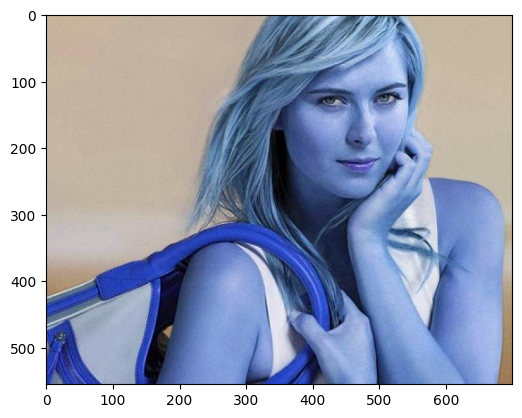

In [11]:
plt.imshow(img)

In [12]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(555, 700)

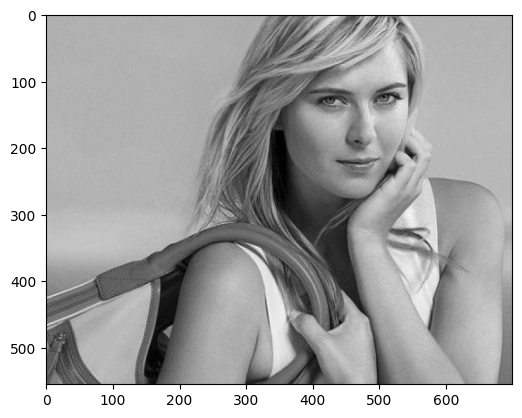

In [13]:
plt.imshow(gray, cmap="gray")

faces = x,y, w, h

In [14]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))
faces

array([[352,  38, 233, 233]])

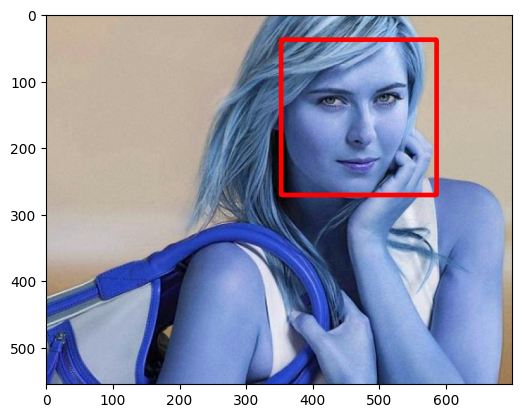

In [15]:
(x,y,w,h) = faces[0]
face_img = cv2.rectangle(img, (x,y),(x+w, y+h), (255, 0, 0), 5)
plt.imshow(face_img)

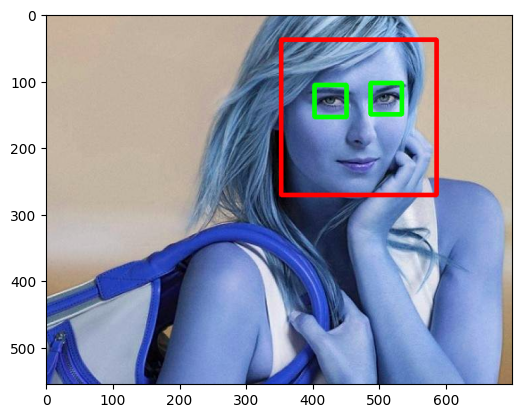

In [16]:
cv2.destroyAllWindows()
for(x,y,w ,h) in faces:
    face_img = cv2.rectangle(img, (x,y) , (x+w , y+h), (255,0,0),5)
    roi_gray = gray[y:y+h, x : x+ w]
    roi_color = face_img [y:y+h, x : x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for(ex, ey, ew ,eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ ew, ey+ eh), (0,255,0), 6)
plt.figure()
plt.imshow(face_img, cmap="gray")
plt.show()

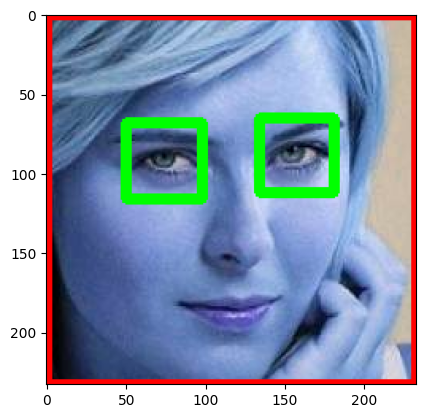

In [17]:
plt.imshow(roi_color)

In [18]:
def get_cropped_img(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, h, w) in faces : 
        roi_color= img[y : y+h, x : x+w]
        roi_gray= gray[y : y+h, x : x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

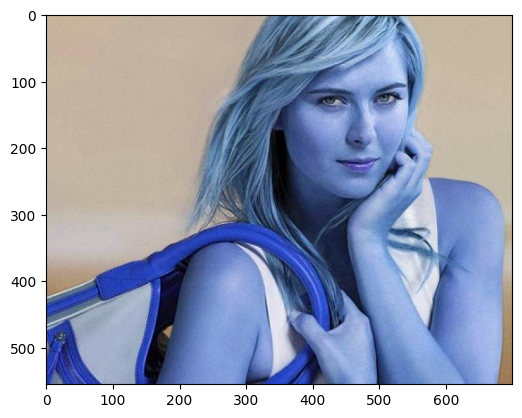

In [19]:
ori_img = cv2.imread('dataset\maria_sharapova\sharapova-hits-the-practice-courts-and-met-ball-kids.jpg')
plt.imshow(ori_img)

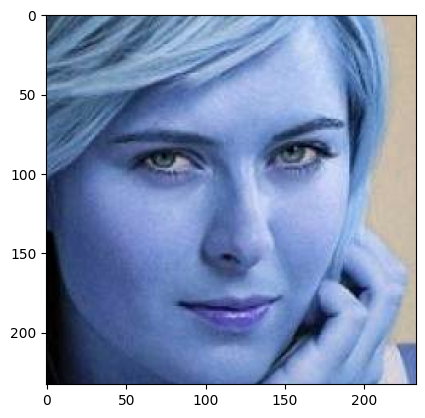

In [20]:
cropped_img = get_cropped_img(r'D:\6th sem\Machine Learning\Projects\project2\model\dataset\maria_sharapova\sharapova-hits-the-practice-courts-and-met-ball-kids.jpg')
plt.imshow(cropped_img)

In [21]:
path_to_data = './dataset/'
path_to_cr_data = './dataset/cropped/'

In [22]:
import os 
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [23]:
img_dirs

['./dataset/cropped',
 './dataset/lionel_messi',
 './dataset/maria_sharapova',
 './dataset/roger_federer',
 './dataset/serena_williams',
 './dataset/virat_kohli']

In [24]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [25]:
cropped_images_dirs = []
celebrity_file_names_dict  = {}
for images_dir in img_dirs:
    count = 1
    celebrity_name = images_dir.split('/')[-1]
    print(celebrity_name)
    celebrity_file_names_dict[celebrity_name] = []
    # 
    for entry in os.scandir(images_dir):
        roi_color = get_cropped_img(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                print("Generating cropped images", cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path , roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

cropped
lionel_messi
Generating cropped images ./dataset/cropped/lionel_messi
maria_sharapova
Generating cropped images ./dataset/cropped/maria_sharapova
roger_federer
Generating cropped images ./dataset/cropped/roger_federer
serena_williams
Generating cropped images ./dataset/cropped/serena_williams
virat_kohli
Generating cropped images ./dataset/cropped/virat_kohli


feature engineering

In [52]:
import  pywt
import cv2
def w2d (img, mode = "haar" , level = 1):
    imArray = img 
    imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)
    imArray = np.float64(imArray)
    imArray /= 255
    coeffs = pywt.wavedec2(imArray, mode, level=level)

    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0

    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    return imArray_H

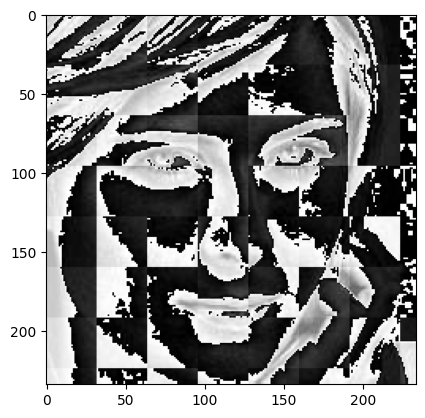

In [53]:
im_har = w2d(cropped_img, 'db1', 5)
plt.imshow(im_har, cmap="gray")

In [54]:
celebrity_file_names_dict.keys()

dict_keys(['cropped', 'lionel_messi', 'maria_sharapova', 'roger_federer', 'serena_williams', 'virat_kohli'])

In [55]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count +=1
class_dict.pop('cropped')
class_dict

{'lionel_messi': 1,
 'maria_sharapova': 2,
 'roger_federer': 3,
 'serena_williams': 4,
 'virat_kohli': 5}

In [56]:
X = []
y = []


for celebrity_name , training_files in celebrity_file_names_dict.items():
    for traininig_image in training_files : 
        img = cv2.imread(traininig_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32,32))
        combine_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1) , scalled_img_har.reshape(32*32,1)))
        X.append(combine_img)
        y.append(class_dict[celebrity_name])

In [57]:
len(X)

165

In [58]:
32 * 32 * 3 + 32 * 32
len(X[0])  # size of each img 

4096

In [59]:
X = np.array(X) .reshape(len(X), 4096).astype(float)
X.shape

(165, 4096)

In [60]:
X[0]

array([100., 129., 140., ..., 238., 232., 230.])

Model training 

using svm with rbf kernal tuned with heuristic finetuning

In [61]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [62]:
X_train, X_test, y_train , y_test = train_test_split(X, y , test_size=.2, random_state=0)

In [63]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])

In [64]:
pipe.score(X_test, y_test)

0.8181818181818182

In [65]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           1       0.57      0.80      0.67         5
           2       1.00      0.56      0.71         9
           3       1.00      1.00      1.00         4
           4       0.80      0.80      0.80         5
           5       0.83      1.00      0.91        10

    accuracy                           0.82        33
   macro avg       0.84      0.83      0.82        33
weighted avg       0.85      0.82      0.81        33



checking if any model with high accuracy 
using GridSearch 

In [66]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [67]:
model_params = {
    'svm' : {
        'model' : svm.SVC (gamma = 'auto', probability = True), 
        'params' : {
            'svc__C' : [1,10,100, 1000],
            'svc__kernel' : ['rbf' , 'linear']
        }
    },
    'random_forest' : {
        'model' : RandomForestClassifier(), 
        'params' : {
            'randomforestclassifier__n_estimators' : [1,5,10]
        }
    },
    'logistic_regression' : {
        'model' : LogisticRegression(solver='liblinear', multi_class='auto'),
        'params' : {
            'logisticregression__C' :[1,5,10]
        }
    }
}

In [68]:
import pandas as pd

In [69]:
scores = []
best_estimator = {}
for algo , mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe , mp['params'], cv =5 , return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model' : algo,
        'best_score' : clf.best_score_, 
        'best_params' :  clf.best_params_
    })
    best_estimator[algo] = clf.best_estimator_
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.871225,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.621368,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.901709,{'logisticregression__C': 10}


In [70]:
best_estimator

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=10, solver='liblinear'))])}

In [71]:
best_estimator['svm'].score(X_test, y_test)

0.8484848484848485

In [72]:
best_estimator['logistic_regression'].score(X_test, y_test)

0.7878787878787878

In [73]:
best_estimator['random_forest'].score(X_test, y_test)

0.7575757575757576

above cells shows more accuracy on svm

In [74]:
best_clf = best_estimator['svm']
best_clf2 = best_estimator['logistic_regression']

In [75]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm2 = confusion_matrix(y_test, best_clf2.predict(X_test))

Text(95.72222222222221, 0.5, 'truth')

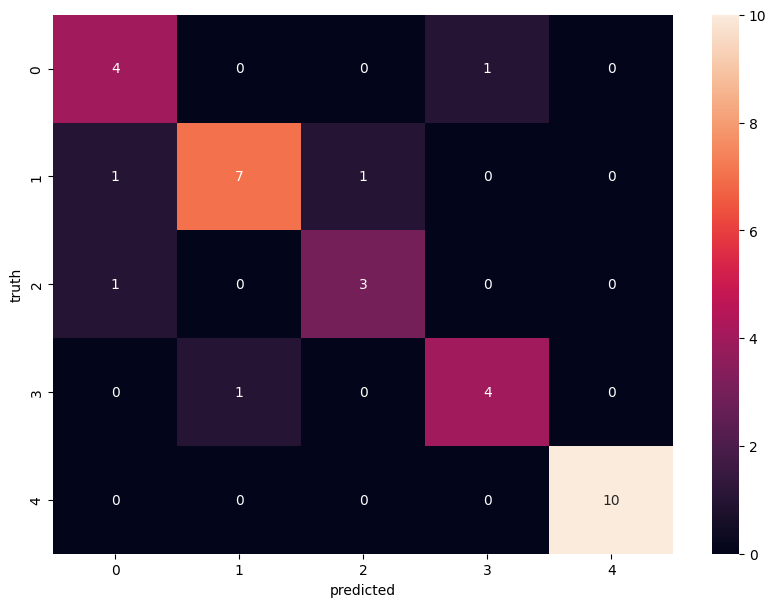

In [76]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('predicted')
plt.ylabel('truth')

<Axes: >

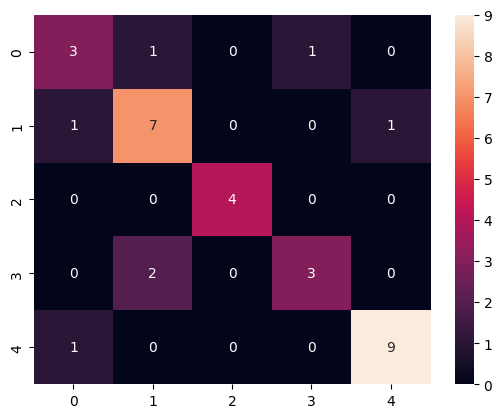

In [77]:
sn.heatmap(cm2, annot=True)


In [78]:
class_dict

{'lionel_messi': 1,
 'maria_sharapova': 2,
 'roger_federer': 3,
 'serena_williams': 4,
 'virat_kohli': 5}

In [79]:
import joblib

joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [80]:
import json
with open ('class_dict.json', "w") as f:
    f.write(json.dumps(class_dict))